**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* #Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* #Apply a distortion correction to raw images.
* #Use color transforms, gradients, etc., to create a thresholded binary image.
* #Apply a perspective transform to rectify binary image ("birds-eye view").
* #Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

** TWE **
* Outlier detection
* time dependent filtering
* plausibilisierung mit lane distane 

# Camera Calibration

In [173]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [174]:
from lib.camera import Camera

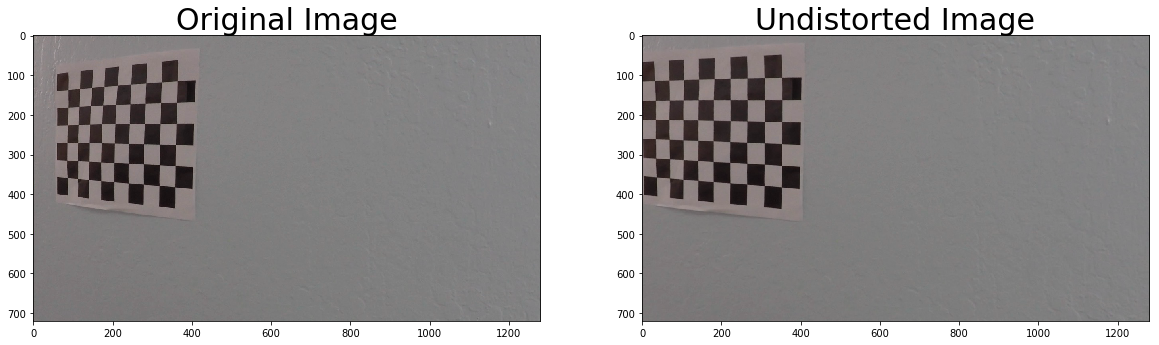

In [175]:
cam = Camera()
#cam.calibrate('camera_cal')
#cam.save_calibration()
cam.load_calibration()

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration19.jpg')
#img_size = (img.shape[1], img.shape[0])

# Undistort image using camera matrix
#dst = cv2.undistort(img, mtx, dist, None, mtx)
dst = cam.undistort_img(img);
#cv2.imwrite('camera_cal/calibration19_calibrated.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30);

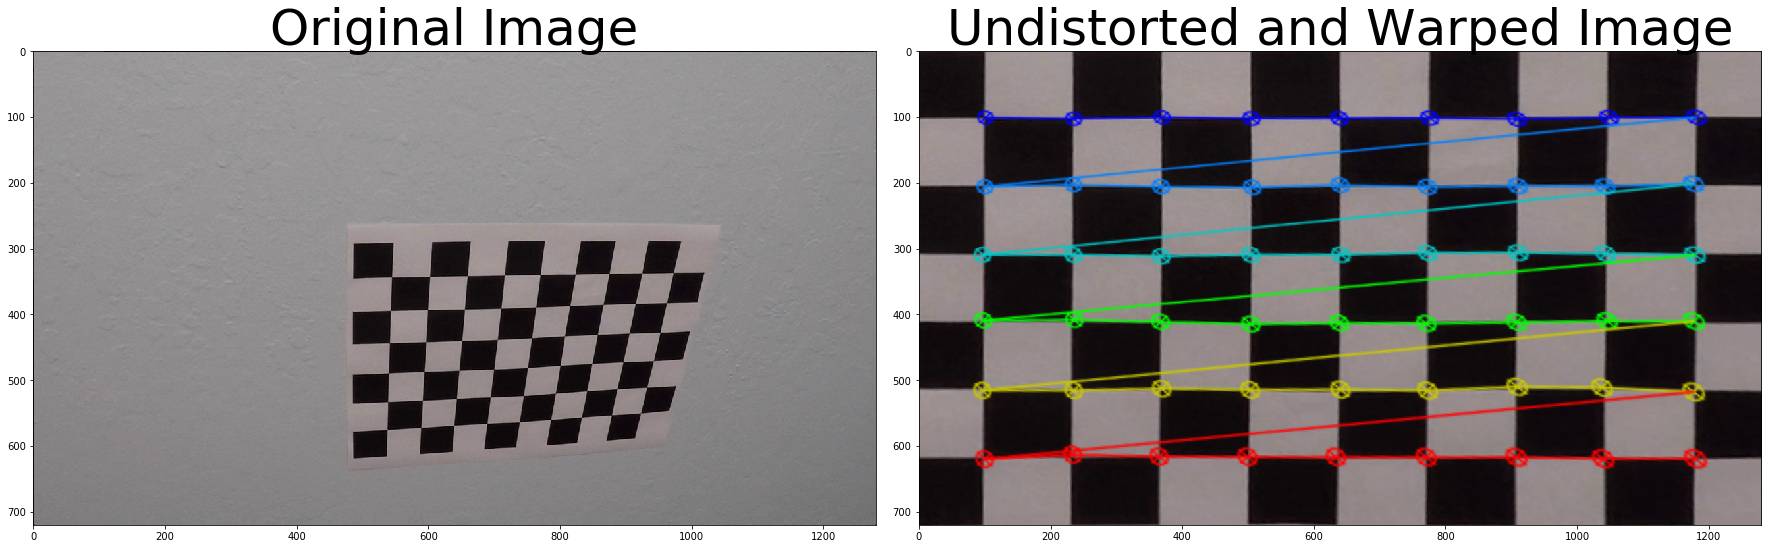

In [176]:
# Read in an image
img = cv2.imread('camera_cal/calibration10.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M = cam.corners_unwarp(img, nx, ny)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

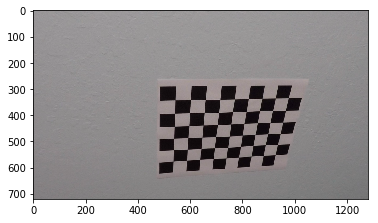

In [177]:
dst = cam.undistort_img(img)
plt.imshow(dst)
plt.show()

(720, 1280, 3)


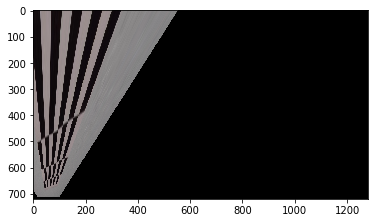

In [178]:
bird = cam.warp_birdeye(dst)
print(bird[0].shape)
plt.imshow(bird[0])
plt.show()

In [180]:
from lib.image_filter import ImageFilter

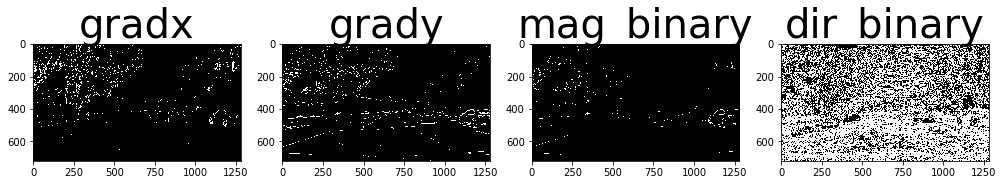

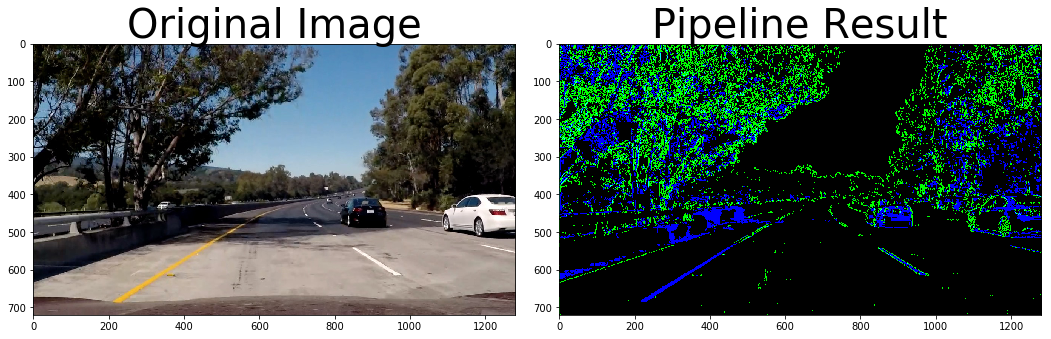

In [181]:
# Load image
image = cv2.imread('color-shadow-example.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = ImageFilter.abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 255))
grady = ImageFilter.abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 255))
mag_binary = ImageFilter.mag_thresh(image, sobel_kernel=ksize, mag_thresh=(100, 255))
dir_binary = ImageFilter.dir_threshold(image, sobel_kernel=ksize, dir_thresh=(np.pi/4, np.pi/2))
result, result2 = ImageFilter.pipeline(image)

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 9))
f.tight_layout()
ax1.imshow(gradx,cmap='gray');      ax1.set_title('gradx', fontsize=40)
ax2.imshow(grady,cmap='gray');      ax2.set_title('grady', fontsize=40)
ax3.imshow(mag_binary,cmap='gray'); ax3.set_title('mag_binary', fontsize=40)
ax4.imshow(dir_binary,cmap='gray'); ax4.set_title('dir_binary', fontsize=40)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(image);  ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result); ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

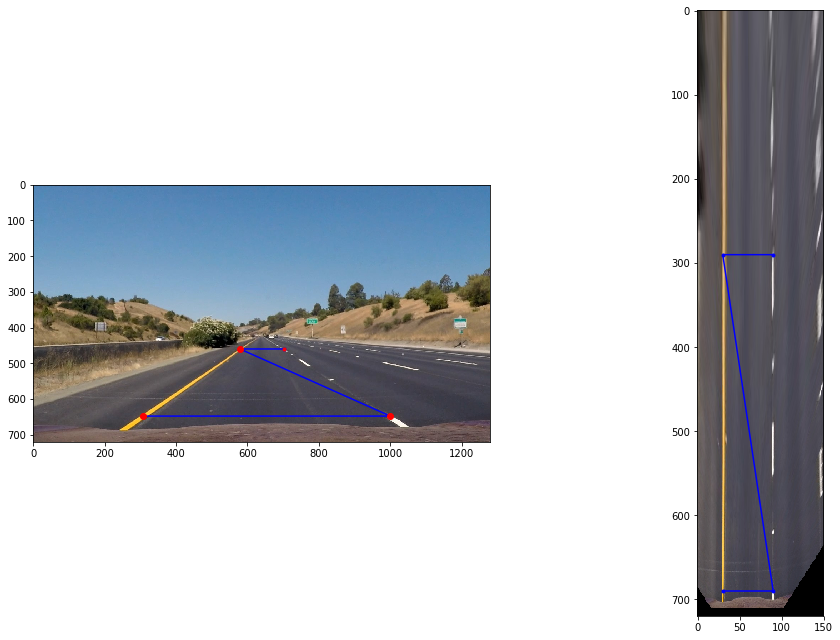

In [12]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_warp, src, dst, M, Minv = cam.warp_birdeye(image)
#image_warp, src, dst, M, Minv = warp_birdeye(image)
#print(src)
#print(dst)

#bird = warp_birdeye(dst)
#print(bird.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
#f, (ax1) = plt.subplots(1, 1, figsize=(14, 14))
f.tight_layout()
ax1.imshow(image)
ax1.plot(src[:,0],src[:,1],'b.-')
ax1.plot(src[0,0],src[0,1],'ro')
ax1.plot(src[1,0],src[1,1],'ro')
ax1.plot(src[2,0],src[2,1],'ro')
ax1.plot(src[3,0],src[3,1],'r.')
ax2.imshow(image_warp[0:,:150,:])
ax2.plot(dst[:,0],dst[:,1],'b.-')
plt.show()

In [182]:
from lib.lane_detector import LaneDetector

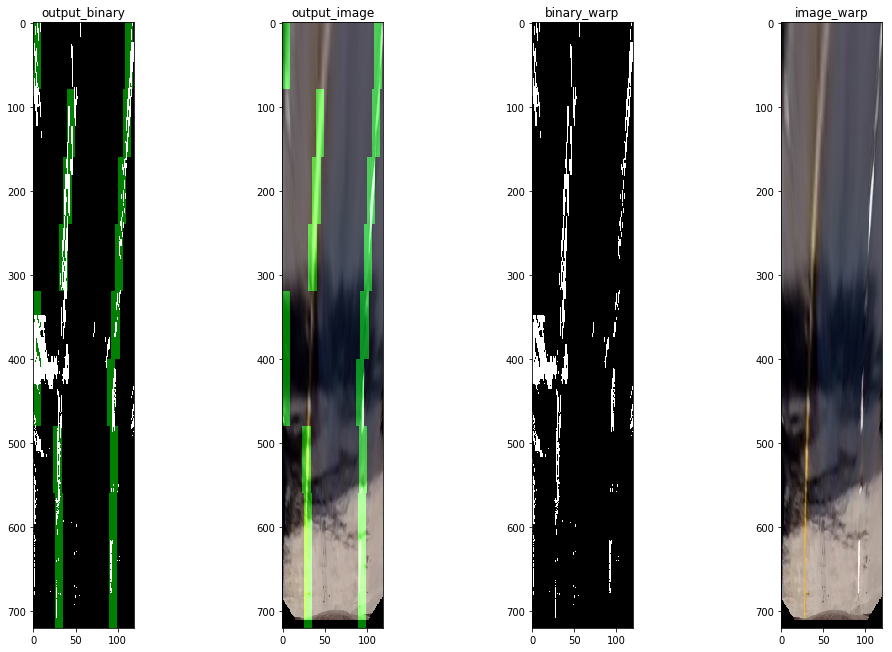

In [138]:
#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

ld = LaneDetector()
(images, window_centroids) = ld.pipeline(cam, ImageFilter, image)
  
# Display the final results
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 9))
f.tight_layout()
ax1.imshow(images[0]); ax1.set_title('output_binary')
ax2.imshow(images[1]); ax2.set_title('output_image')
ax3.imshow(images[2],cmap='gray'); ax3.set_title('binary_warp')
ax4.imshow(images[3]); ax4.set_title('image_warp')
plt.show()    

In [139]:
# Define a class to receive the characteristics of each line detection
class LaneLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #
        self.left_fit = None
        self.right_fit = None

    def fit(self, leftx, rightx):
        # Fit a second order polynomial to pixel positions in each fake lane line
        self.left_fit   = np.polyfit(ploty, leftx, 2)
        self.right_fit  = np.polyfit(ploty, rightx, 2)
        
#        left_fitx  = self.left_fit[0]*ploty**2  + self.left_fit[1]*ploty  + self.left_fit[2]
#        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
#        return (left_fitx, right_fitx)
    
    def fit_world(self, ploty, leftx, rightx): # Das stimmt was nicht ploty länge ist nicht leftx länge
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    def get_plot(self, ploty):
        left_fitx  = self.left_fit[0]*ploty**2  + self.left_fit[1]*ploty  + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        return (left_fitx, right_fitx)
 
    def get_radius(self):
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m        
        
    def generate_road(self, window_height):
        ploty = (window_height/2 + np.linspace(0, 630, num=720)) / 1
        left_fitx  = self.left_fit[0]*ploty**2  + self.left_fit[1]*ploty  + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

    def get_next(self):
        return "TODO"

In [153]:
data   = np.array(window_centroids)
ploty  = (ld.window_height/2 + np.linspace(0, 630, num=720/ld.window_height)) / 1
leftx  = data[:,0]
rightx = data[:,1]

lane = LaneLine();
lane.fit(leftx, rightx)
lane.generate_road(ld.window_height)
result = ld.draw_lanes_warped(lane, image)

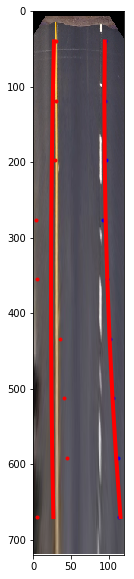

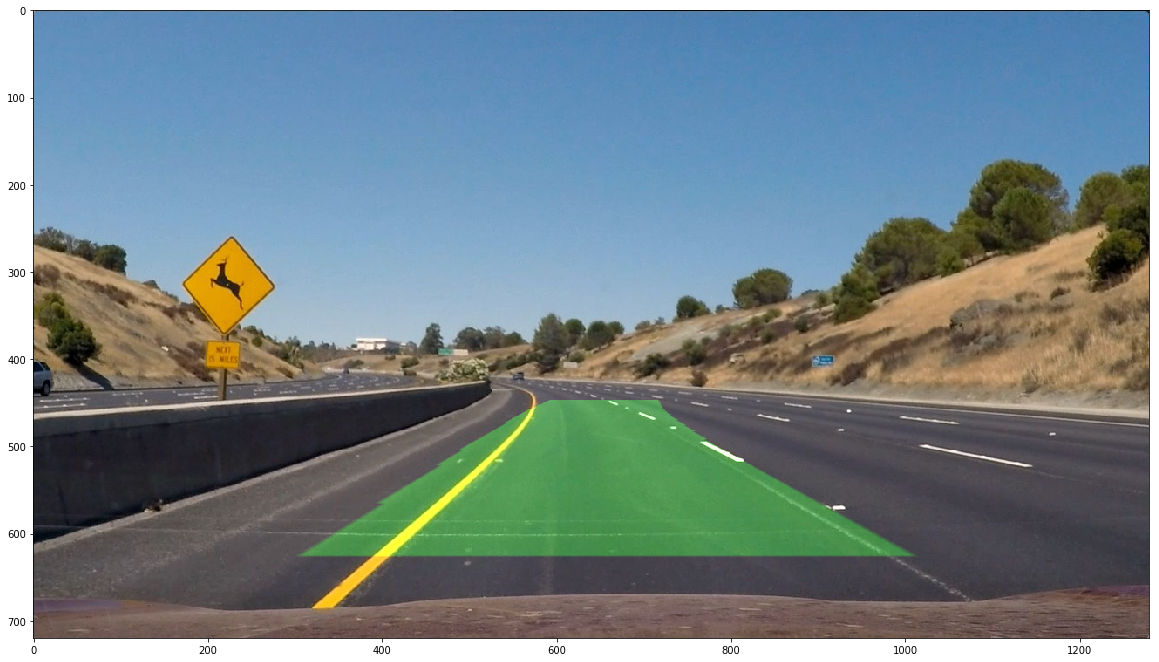

In [154]:
# Plot up the fake data
plt.figure(figsize=(20,10))
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
#plt.xlim(0, 1280)
#plt.ylim(0, 720)
plt.xlim(0, 120)
plt.ylim(0, 720)
plt.imshow(np.flipud(image_warp))
plt.plot(left_fitx, ploty, color='red', linewidth=4)
plt.plot(right_fitx, ploty, color='red', linewidth=4)
plt.gca().invert_yaxis() # to visualize as we do the images

plt.figure(figsize=(20,14))
plt.imshow(result)
plt.show();

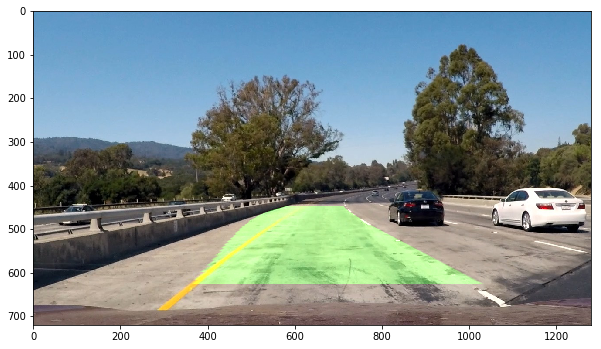

In [160]:
def process_image(image):
    # The output you return should be a color image (3 channel) for processing video below
    ld = LaneDetector()
    (images, window_centroids) = ld.pipeline(cam, ImageFilter, image);
    data   = np.array(window_centroids)
    leftx  = data[:,0]
    rightx = data[:,1]
    lane = LaneLine();
    lane.fit(leftx, rightx)
    result = ld.draw_lanes_warped(lane, image)
    return result

#image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = process_image(image)
plt.figure(figsize=(20/2,14/2))
plt.imshow(result)
plt.show();

In [158]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time

In [164]:
video_output = 'project_video_lane_detection.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_lane_detection.mp4
[MoviePy] Writing video project_video_lane_detection.mp4



100%|█████████▉| 1260/1261 [04:15<00:00,  4.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane_detection.mp4 

CPU times: user 6min 12s, sys: 1min 5s, total: 7min 18s
Wall time: 4min 17s


In [166]:
filename = video_output + ( "?t=" + str(time.time()) ); # disable firefox video caching by adding random number
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(filename))

In [159]:
video_output = 'challenge_video_lane_detection.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_lane_detection.mp4
[MoviePy] Writing video challenge_video_lane_detection.mp4



100%|██████████| 485/485 [01:29<00:00,  5.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_lane_detection.mp4 

CPU times: user 2min 11s, sys: 23.9 s, total: 2min 35s
Wall time: 1min 31s


In [161]:
filename = video_output + ( "?t=" + str(time.time()) ); # disable firefox video caching by adding random number
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(filename))

In [162]:
video_output = 'harder_challenge_video_lane_detection.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_lane_detection.mp4
[MoviePy] Writing video harder_challenge_video_lane_detection.mp4



100%|█████████▉| 1199/1200 [05:00<00:00,  5.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_lane_detection.mp4 

CPU times: user 7min 24s, sys: 1min 14s, total: 8min 38s
Wall time: 5min 2s


In [163]:
filename = video_output + ( "?t=" + str(time.time()) ); # disable firefox video caching by adding random number
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(filename))

# OLD

In [344]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

8099.07005604 11099.9682618


[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
###Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
###Writeup / README

####1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!
###Camera Calibration

####1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]

###Pipeline (single images)

####1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
![alt text][image2]
####2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

![alt text][image3]

####3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]

####4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

![alt text][image5]

####5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in `my_other_file.py`

####6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

---

###Pipeline (video)

####1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

###Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  



In [33]:
help(cv2.calibrateCamera)

Help on built-in function calibrateCamera:

calibrateCamera(...)
    calibrateCamera(objectPoints, imagePoints, imageSize, cameraMatrix, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]) -> retval, cameraMatrix, distCoeffs, rvecs, tvecs



In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
#leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                              for y in ploty])
#rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                for y in ploty])
#
#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y